In [1]:
# 匯入必要套件
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# 設定資料夾路徑
data_path = "TVSdata"
# 確保 modeldata 資料夾存在，否則自動建立
model_path = "TVSmodel"
os.makedirs(model_path, exist_ok=True)

In [3]:
# 輸入元件編號（例如 D5094 或 D9414）
PartNumber = input("輸入元件編號（例如 D5094 或 D9414）：")

# 組合完整檔案路徑
file_path = os.path.join(data_path, "TVSdata_"+PartNumber+".xlsx")
# print(file_path)

輸入元件編號（例如 D5094 或 D9414）： D9414


In [4]:
# 檢查檔案是否存在
if os.path.isfile(file_path):
    # 嘗試讀取 Excel 檔案
    try:
        df = pd.read_excel(file_path)
        print("檔案載入成功！")
        # 顯示前幾筆資料作為確認
        print(df.head())
    except Exception as e:
        print(f"檔案讀取失敗，錯誤訊息：{e}")
else:
    print("檔案不存在，請確認輸入的檔名是否正確。")

檔案載入成功！
     UniNumber     BiNumber UniCode BiCode  Vrwm  Vbr_min  Vbr_max  It   Ir  \
0  D9414-110UF  D9414-110UF     PDZ    DDZ    11     12.2     13.5   1  800   
1  D9414-120UF  D9414-120UF     PEE    DEE    12     13.3     14.7   1  800   
2  D9414-130UF  D9414-130UF     PEG    DEG    13     14.4     15.9   1  500   
3  D9414-140UF  D9414-140UF     PEK    DEK    14     15.6     17.2   1  200   
4  D9414-150UF  D9414-150UF     PEM    DEM    15     16.7     18.5   1  200   

   Vc_1  Ipp_1  Vc_2  Ipp_2  
0  18.2  164.8   NaN    NaN  
1  19.9  150.8   NaN    NaN  
2  21.5  139.5   NaN    NaN  
3  23.2  129.3   NaN    NaN  
4  24.4  123.0   NaN    NaN  


In [5]:
# 清洗資料
df_clean = df.dropna(subset=["Vc_1", "Ipp_1", "Vc_2", "Ipp_2"])

X = df_clean[["Vc_1", "Ipp_1"]].values
y = df_clean[["Vc_2", "Ipp_2"]].values
# 標準化
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [6]:
import joblib
joblib.dump(scaler_X, os.path.join(model_path,"scaler_X_"+PartNumber+".pkl"))
joblib.dump(scaler_y, os.path.join(model_path,"scaler_y_"+PartNumber+".pkl"))

['TVSmodel\\scaler_y_D9414.pkl']

In [7]:
# 分割訓練/測試
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [8]:
# 建立 Keras MLP 模型
model = Sequential([
    Dense(64, input_shape=(2,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(2)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(X_train, y_train, epochs=1500, batch_size=4, verbose=0, validation_split=0.2)

In [9]:
print('Train Loss:', history.history['loss'][-1])
print('Val Loss:', history.history['val_loss'][-1])

Train Loss: 0.0
Val Loss: 0.2433621734380722


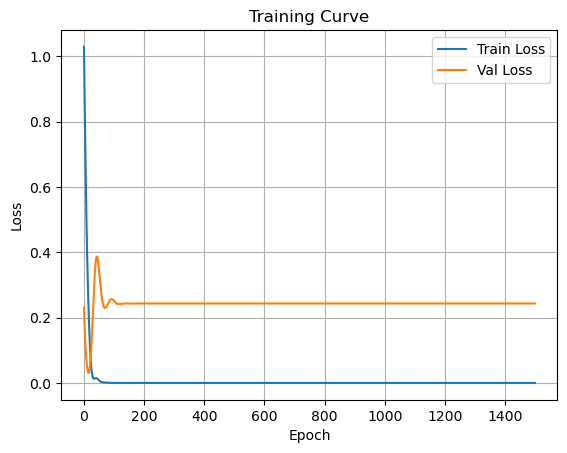

In [10]:
# 繪製 Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# 儲存模型
model.save(os.path.join(model_path,"TVSmodel_"+PartNumber+".h5"))

In [12]:
# 預測與反標準化
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

1/1 [==============================] - 0s 49ms/step


In [13]:
# 顯示部分預測結果
result_df = pd.DataFrame({
    "Vc_2_Pred": y_pred[:, 0],
    "Ipp_2_Pred": y_pred[:, 1],
    "Vc_2_True": y_true[:, 0],
    "Ipp_2_True": y_true[:, 1]
})
print(result_df.head())

   Vc_2_Pred  Ipp_2_Pred  Vc_2_True  Ipp_2_True
0  64.713264  739.963318       61.9       784.0
